In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sklearn as sk
from sklearn import decomposition as dec
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.utils.prune as prune
import sklearn.manifold as nonlin
import pickle as pk
from sklearn.metrics import accuracy_score


# Cifar 10

## Isomap

In [3]:
class NN2(nn.Module):
    def __init__(self, is_norm=False):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=12, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=16, kernel_size=(5, 5))
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.soft = nn.Softmax(dim=0)
        self.is_norm = is_norm
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if(self.is_norm == True):
            x = nn.functional.normalize(self.fc3(x))
        else:
            x = self.fc3(x)
        return x


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

mnist_train = torchvision.datasets.MNIST(root='./data', train=True,
                                         download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)

trainloader_mnist = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                shuffle=True, num_workers=2)
testloader_mnist = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                               shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
mnist_dataset_sample = iter(testloader_mnist)
sample_im, sample_lbl = mnist_dataset_sample.next()

cifar_dataset_sample = iter(testloader)
cifar_sample_im, cifar_sample_lbl = cifar_dataset_sample.next()


In [6]:
def similarity(model1, model2, image):
    original_network = model1(image)
    small_network = model2(image)



    # dis = torch.pairwise_distance(original_network, small_network)
    # for a in dis:
    #     sim = 1/(a + 1) * 100
    #     print(sim)

    print('cosine similarity')
    cos = nn.CosineSimilarity()
    return cos(original_network, small_network) * 100


In [7]:
#ica
path_cifar_original = './ica_reduced_network/cifar/cifar_original_net.pt'

path_cifar_ica_ = './ica_reduced_network/cifar/ica_cifar_network.pt'
path_cifar_ica_trained = './ica_reduced_network/cifar/ica_cifar_network_retrained.pt'
path_cifar_ica_small= './ica_reduced_network/cifar/small_network_cifar.pt'

path_cifar_prune = './ica_reduced_network/cifar/pruned/pruned_cifar_net.pt'
path_cifar_ica_pruned = './ica_reduced_network/cifar/pruned/ica_pruned_net_cifar.pt'

#isomap
path_isomap_cifar_original = './isomap_reduced_network/cifar/cifar_original_net.pt'

path_cifar_isomap = './isomap_reduced_network/cifar/cifar_untrained_dr_network.pt'
path_cifar_isomap_trained = './isomap_reduced_network/cifar/cifar_trained_dr_network.pt'
path_cifar_isomap_small= './isomap_reduced_network/cifar/cifar_small_net_scratch.pt'

path_cifar_prune_isomap = './isomap_reduced_network/cifar/pruned/pruned_cifar_original_net.pt'
path_cifar_isomap_pruned = './isomap_reduced_network/cifar/pruned/dr_pruned_cifar_network.pt'

#pca
path_pca_cifar_original = './pca_reduced_networks/cifar/cifar_original_net.pt'

path_cifar_pca = './pca_reduced_networks/cifar/cifar_dr_original_net.pt'
path_cifar_pca_trained = './pca_reduced_networks/cifar/cifar_dr_net_retrained_retrained.pt'
path_cifar_pca_small = './pca_reduced_networks/cifar/net_reconstructed_from_scratch.pt'

path_cifar_pruned_nopca = './pca_reduced_networks/cifar/pruned/pruned_cifar_net.pt'
path_cifar_pca_pruned = './pca_reduced_networks/cifar/pruned/pruned_pca_cifar_net.pt'
path_cifar_sparsepca_pruned = './pca_reduced_networks/cifar/pruned/pruned_sparsepca_cifar_net.pt'



In [10]:
cifar_ica_model = torch.load(path_cifar_ica_)
cifar_original_net = torch.load(path_cifar_original)


y_pred = cifar_ica_model(cifar_sample_im)
print(y_pred)

tensor([[ -4.3596,   1.9592,   1.2397,  -0.7367,  -1.6998,  -1.4572,  12.4758,
         -12.3425,   4.5221,  -0.2722],
        [  8.1959,  43.7692,  -2.3862, -28.3771, -14.6604, -28.0448,  24.2113,
         -35.3271,  26.2922,  12.8303],
        [  0.3954,   9.2260,  -0.4063,  -1.7658,  -0.8873,  -2.2870,  -1.0942,
          -4.0232,   3.3120,  -1.7183],
        [ 13.0793,   5.3156,   4.6372, -11.3323,   4.2828, -16.4759,   8.3627,
         -16.7516,  21.8437,  -3.1885]], grad_fn=<MmBackward0>)


In [32]:
cifar_model_original = torch.load(path_cifar_original)

cifar_ica_model_untrained = torch.load(path_cifar_ica_)
cifar_ica_model_trained = torch.load(path_cifar_ica_trained)
cifar_small_network = torch.load(path_cifar_ica_small)

cifar_pruned_net = torch.load(path_cifar_prune)
cifar_ica_pruned_net = torch.load(path_cifar_ica_pruned)
cifar_model_original_isomap = torch.load(path_isomap_cifar_original)

cifar_isomap_model_untrained = torch.load(path_cifar_isomap)
cifar_isomap_model_trained = torch.load(path_cifar_isomap_trained)
cifar_small_network_isomap = torch.load(path_cifar_isomap_small)

cifar_pruned_net_isomap = torch.load(path_cifar_prune_isomap)
cifar_ica_pruned_net_isomap = torch.load(path_cifar_isomap_pruned)
cifar_model_original_cifar = torch.load(path_pca_cifar_original)

cifar_cifar_model_untrained = torch.load(path_cifar_pca)
cifar_cifar_model_trained = torch.load(path_cifar_pca_trained)
cifar_cifar_network_cifar = torch.load(path_cifar_pca_small)

cifar_pruned_net_cifar = torch.load(path_cifar_pruned_nopca)
cifar_pca_pruned_net_cifar = torch.load(path_cifar_pca_pruned)
cifar_sparsepca_pruned_net_cifar = torch.load(path_cifar_sparsepca_pruned)



In [38]:
print('untrained')
print(similarity(cifar_model_original, cifar_ica_model_untrained, cifar_sample_im).sum().item()/4)
print('trained')
print(similarity(cifar_model_original, cifar_ica_model_trained, cifar_sample_im).sum().item()/4)
print('small network')
print(similarity(cifar_model_original,
      cifar_small_network, cifar_sample_im).sum().item()/4)

print('pruned network')
print(similarity(cifar_model_original,
      cifar_pruned_net, cifar_sample_im).sum().item()/4)

print('pruned nad ica network')
print(similarity(cifar_model_original,
      cifar_ica_pruned_net, cifar_sample_im).sum().item()/4)


untrained
cosine similarity
54.399253845214844
trained
cosine similarity
86.62223052978516
small network
cosine similarity
71.71365356445312
pruned network
cosine similarity
95.29688262939453
pruned nad ica network
cosine similarity
45.23316192626953


In [52]:
# cifar_model_original_cifar = torch.load(path_pca_cifar_original)

# cifar_cifar_model_untrained = torch.load(path_cifar_pca)
# cifar_cifar_model_trained = torch.load(path_cifar_pca_trained)
# cifar_cifar_network_cifar = torch.load(path_cifar_pca_small)

# cifar_pruned_net_cifar = torch.load(path_cifar_pruned_nopca)
# cifar_ica_pruned_net_cifar = torch.load(path_cifar_pca_pruned)
# cifar_sparsepca_pruned_net_cifar = torch.load(path_cifar_sparsepca_pruned)

print('untrained')
print(similarity(cifar_model_original_cifar, cifar_cifar_model_untrained, cifar_sample_im).sum().item()/4)
print('trained')
print(similarity(cifar_model_original_cifar, cifar_cifar_model_trained, cifar_sample_im).sum().item()/4)
print('small network')
print(similarity(cifar_model_original_cifar,
      cifar_cifar_network_cifar, cifar_sample_im).sum().item()/4)

print('pruned network')
print(similarity(cifar_model_original_cifar,
      cifar_pruned_net_cifar, cifar_sample_im).sum().item()/4)

print('pruned nad pca network')
print(similarity(cifar_model_original_cifar,
      cifar_pca_pruned_net_cifar, cifar_sample_im).sum().item()/4)

print('pruned nad sparse pca network')
print(similarity(cifar_model_original_cifar,
      cifar_sparsepca_pruned_net_cifar, cifar_sample_im).sum().item()/4)


untrained
cosine similarity
27.169414520263672
trained
cosine similarity
27.169414520263672
small network
cosine similarity
83.13453674316406
pruned network
cosine similarity
89.31993103027344
pruned nad pca network
cosine similarity
31.051809310913086
pruned nad sparse pca network
cosine similarity
53.72847366333008


In [54]:
print('untrained')
print(similarity(cifar_model_original,
      cifar_isomap_model_untrained, cifar_sample_im).sum().item()/4)
print('trained')
print(similarity(cifar_model_original_isomap,
      cifar_cifar_model_trained, cifar_sample_im).sum().item()/4)
print('small network')
print(similarity(cifar_model_original_isomap,
      cifar_small_network_isomap, cifar_sample_im).sum().item()/4)

print('pruned network')
print(similarity(cifar_model_original_isomap,
      cifar_pruned_net_isomap, cifar_sample_im).sum().item()/4)

print('pruned nad ica network')
print(similarity(cifar_model_original_isomap,
      cifar_ica_pruned_net_isomap, cifar_sample_im).sum().item()/4)


untrained
cosine similarity
47.338218688964844
trained
cosine similarity
27.169414520263672
small network
cosine similarity
71.64712524414062
pruned network
cosine similarity
85.79837799072266
pruned nad ica network
cosine similarity
37.30654525756836


# Mnist

In [55]:
#ica
path_cifar_original = './ica_reduced_network/mnist/original_network_mnist.pt'

path_cifar_ica_ = './ica_reduced_network/mnist/ica_mnist_network.pt'
path_cifar_ica_trained = './ica_reduced_network/mnist/ica_mnist_retrained_network.pt'
path_cifar_ica_small= './ica_reduced_network/mnist/small_mnist_network.pt'

path_cifar_prune = './ica_reduced_network/mnist/pruned/pruned_original_network_mnist.pt'
path_cifar_ica_pruned = './ica_reduced_network/mnist/pruned/ica_pruned_network_mnist.pt'

#isomap
path_isomap_cifar_original = './isomap_reduced_network/mnist/original_network_mnist.pt'

path_cifar_isomap = './isomap_reduced_network/mnist/isomap_mnsit_network.pt'
path_cifar_isomap_trained = './isomap_reduced_network/mnist/reduced_isomap_retrained.pt'
path_cifar_isomap_small= './isomap_reduced_network/mnist/small_network_scratch_isomap.pt'

path_cifar_prune_isomap = './isomap_reduced_network/mnist/pruned/isomap_pruned_network_mnist.pt'
path_cifar_isomap_pruned = './isomap_reduced_network/mnist/pruned/pruned_original_network.pt'

#pca
path_pca_cifar_original = './pca_reduced_networks/mnist/original_network_mnist.pt'

path_cifar_pca = './pca_reduced_networks/mnist/pca_mnist_network.pt'
path_cifar_pca_trained = './pca_reduced_networks/mnist/pca_mnist.network_retrained.pt'
path_cifar_pca_small = './pca_reduced_networks/mnist/small_network_mnist.pt'

path_cifar_pruned_nopca = './pca_reduced_networks/mnist/pruned/pruned_original_net.pt'
path_cifar_pca_pruned = './pca_reduced_networks/mnist/pruned/pruned_pca_mnist_net.pt'
path_cifar_sparsepca_pruned = './pca_reduced_networks/mnist/pruned/sparse_pca_mnist_network.pt'


## Isomap

In [7]:
class NN(nn.Module):
    def __init__(self, is_normalize):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=12, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(kernel_size=(2), stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=12, out_channels=16, kernel_size=(5, 5))
        self.fc1 = nn.Linear(256, 120) # 256x 60
        self.fc2 = nn.Linear(120, 84) # 60 x 84
        self.fc3 = nn.Linear(84, 10)
        self.soft = nn.Softmax(dim=0)
        self.norm = is_normalize

        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if(self.norm==True):
         x = nn.functional.normalize(self.fc3(x))
        else:
         x = self.fc3(x)
         
        x = self.soft(x)
        return x
    

In [95]:
path_mnist_original_network = './isomap_reduced_network/custom_nn_mnist_isomap_original.pt'
path_mnist_reduced_isomap_retrained = './isomap_reduced_network/reduced_isomap_retrained.pt'
path_mnist_small_network = './isomap_reduced_network/small_network_scratch_isomap.pt'
path_mnist_untrained_reduced_network  ='./isomap_reduced_network/untrained_reduced_network.pt'

In [96]:
mnist_original = torch.load(path_mnist_original_network)
mnist_reduced_isomap_retrained = torch.load(path_mnist_reduced_isomap_retrained)
mnist_small_network = torch.load(path_mnist_small_network)
mnist_untrained_reduced_network = torch.load(path_mnist_untrained_reduced_network)

## plotting graphs for training processes

### cifar ica

In [11]:
def plt_graph(filename, colors, metrics, title):
    color1, color2 = colors
    train, val = metrics
    vis_data_cifar_retrained = filename
    with open(vis_data_cifar_retrained, "rb") as accloss:
        accloss_original_net_retrained = pk.load(accloss)
    print(accloss_original_net_retrained)

    epochs = range(len(accloss_original_net_retrained[train]))

    plt.plot(
        epochs, accloss_original_net_retrained[train],  color1, label='Training {}'.format(train))
    plt.plot(
        epochs, accloss_original_net_retrained[val],  color2, label='Training {}'.format(val))
    # plt.plot(epochs, accloss_original_net_retrained['accuracy'], 'b', label='Training accuracy')
    plt.title(title)

    plt.ylabel(train)
    plt.legend()
    plt.grid('on')
    plt.show()
   


{'accuracy': [37.34444444444444, 53.07111111111111, 58.95777777777778, 63.03333333333333, 65.7, 67.6511111111111, 69.39777777777778, 70.92666666666666, 72.04666666666667, 72.84222222222222], 'loss': [1.7022015121711624, 1.307835097947551, 1.153700749271777, 1.0498797011589838, 0.9783536291898125, 0.9221370999560587, 0.8717433232451892, 0.8298772317114803, 0.7917344206454698, 0.7646757424576673], 'valid acc': [49.68, 55.54, 59.92, 61.84, 63.12, 63.34, 65.18, 65.06, 64.34, 64.7], 'valid loss': [1.4071478605866432, 1.2393506274282933, 1.1366269882798195, 1.0938427864938975, 1.0480796902552247, 1.058200935510546, 1.006912547860667, 1.0192178270950913, 1.070175673634559, 1.0398351033423097]}


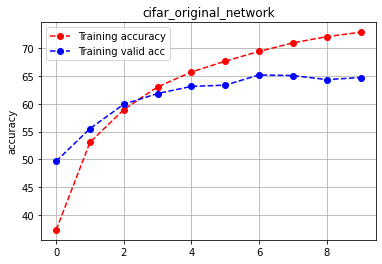

{'accuracy': [37.34444444444444, 53.07111111111111, 58.95777777777778, 63.03333333333333, 65.7, 67.6511111111111, 69.39777777777778, 70.92666666666666, 72.04666666666667, 72.84222222222222], 'loss': [1.7022015121711624, 1.307835097947551, 1.153700749271777, 1.0498797011589838, 0.9783536291898125, 0.9221370999560587, 0.8717433232451892, 0.8298772317114803, 0.7917344206454698, 0.7646757424576673], 'valid acc': [49.68, 55.54, 59.92, 61.84, 63.12, 63.34, 65.18, 65.06, 64.34, 64.7], 'valid loss': [1.4071478605866432, 1.2393506274282933, 1.1366269882798195, 1.0938427864938975, 1.0480796902552247, 1.058200935510546, 1.006912547860667, 1.0192178270950913, 1.070175673634559, 1.0398351033423097]}


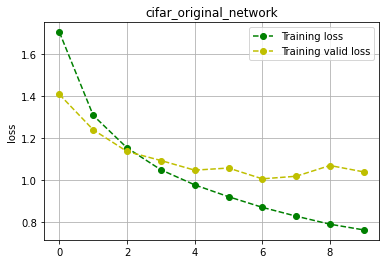

In [25]:
path_cifar_original_network =  './data_vis/ICA/cifar/cifar_original_net_accloss.pickle'
plt_graph(path_cifar_original_network, ('--ro', '--bo'), ('accuracy', 'valid acc'), 'cifar_original_network')
plt_graph(path_cifar_original_network,('--go', '--yo'), ('loss', 'valid loss'), 'cifar_original_network')

{'accuracy': [35.43333333333333, 51.42666666666667, 57.855555555555554, 61.99333333333333, 64.52222222222223, 66.66888888888889, 67.95777777777778, 69.23777777777778, 70.26666666666667, 70.77777777777777], 'loss': [1.734184230895837, 1.3450565647827255, 1.1854865461948845, 1.0805869463589457, 1.012610037761761, 0.9528015365095602, 0.9181271205615666, 0.8845228734108412, 0.8560724392687178, 0.8307765333982314], 'valid acc': [45.82, 55.9, 60.32, 62.72, 64.34, 66.0, 63.48, 65.6, 66.64, 67.42], 'valid loss': [1.4673336116671563, 1.2308315666437148, 1.1295956671774388, 1.0787339588880538, 1.0501010490059852, 0.9909479792550207, 1.0894057121537626, 1.0177808129139245, 0.9830893890038133, 0.9895021423480008]}


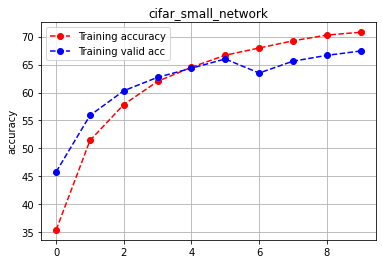

{'accuracy': [35.43333333333333, 51.42666666666667, 57.855555555555554, 61.99333333333333, 64.52222222222223, 66.66888888888889, 67.95777777777778, 69.23777777777778, 70.26666666666667, 70.77777777777777], 'loss': [1.734184230895837, 1.3450565647827255, 1.1854865461948845, 1.0805869463589457, 1.012610037761761, 0.9528015365095602, 0.9181271205615666, 0.8845228734108412, 0.8560724392687178, 0.8307765333982314], 'valid acc': [45.82, 55.9, 60.32, 62.72, 64.34, 66.0, 63.48, 65.6, 66.64, 67.42], 'valid loss': [1.4673336116671563, 1.2308315666437148, 1.1295956671774388, 1.0787339588880538, 1.0501010490059852, 0.9909479792550207, 1.0894057121537626, 1.0177808129139245, 0.9830893890038133, 0.9895021423480008]}


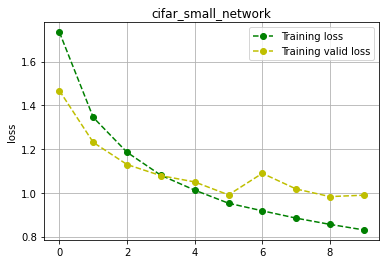

In [26]:
path_small_network_history = './data_vis/ICA/cifar/small_network_cifar_accloss.pickle'
plt_graph(path_small_network_history, ('--ro', '--bo'), ('accuracy', 'valid acc'), 'cifar_small_network')
plt_graph(path_small_network_history,('--go', '--yo'), ('loss', 'valid loss'), 'cifar_small_network')

{'accuracy': [50.175555555555555, 58.73555555555556, 62.28, 63.733333333333334, 65.18444444444444, 66.38888888888889, 67.82222222222222, 68.56888888888889, 69.23333333333333, 69.93111111111111], 'loss': [1.4383567566146453, 1.1996678646534682, 1.1158449644411603, 1.0606424611918628, 1.013410330573635, 0.9833449882791068, 0.9514164409493406, 0.9210677290745183, 0.8967032939017026, 0.8785091361408018], 'valid acc': [54.08, 59.16, 61.2, 62.46, 62.28, 63.48, 62.7, 63.66, 63.92, 64.22], 'valid loss': [1.340224699756503, 1.1865790071457625, 1.14717464697361, 1.1193803860396148, 1.140921713642776, 1.1210664840720594, 1.1418050965040922, 1.138684161669761, 1.0901200274361298, 1.1068331275226548]}


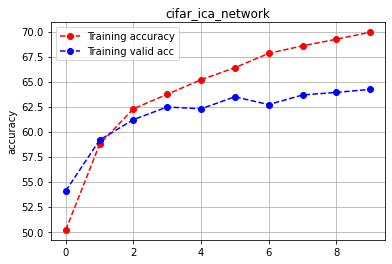

{'accuracy': [50.175555555555555, 58.73555555555556, 62.28, 63.733333333333334, 65.18444444444444, 66.38888888888889, 67.82222222222222, 68.56888888888889, 69.23333333333333, 69.93111111111111], 'loss': [1.4383567566146453, 1.1996678646534682, 1.1158449644411603, 1.0606424611918628, 1.013410330573635, 0.9833449882791068, 0.9514164409493406, 0.9210677290745183, 0.8967032939017026, 0.8785091361408018], 'valid acc': [54.08, 59.16, 61.2, 62.46, 62.28, 63.48, 62.7, 63.66, 63.92, 64.22], 'valid loss': [1.340224699756503, 1.1865790071457625, 1.14717464697361, 1.1193803860396148, 1.140921713642776, 1.1210664840720594, 1.1418050965040922, 1.138684161669761, 1.0901200274361298, 1.1068331275226548]}


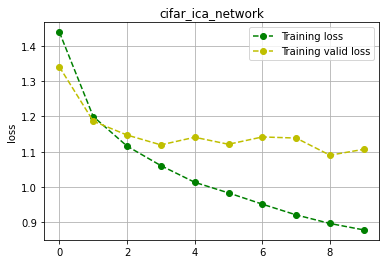

In [27]:
path_ica_retrained_net_history = './data_vis/ICA/cifar/ica_cifar_retrained_accloss.pickle'
plt_graph(path_ica_retrained_net_history, ('--ro', '--bo'),
          ('accuracy', 'valid acc'), 'cifar_ica_network')
plt_graph(path_ica_retrained_net_history, ('--go', '--yo'),
          ('loss', 'valid loss'), 'cifar_ica_network')


### mnist ica

{'accuracy': [90.364, 97.956, 98.556, 98.85, 99.066], 'loss': [0.29661258739920565, 0.06425467679866706, 0.04648363661678762, 0.03605110859342766, 0.02846996144483688], 'valid acc': [0.08052627056272758, 0.053801242265346653, 0.06376210520519271, 0.05315261922943194, 0.042732843348358036], 'valid loss': [97.64, 98.34, 98.11, 98.49, 98.88]}


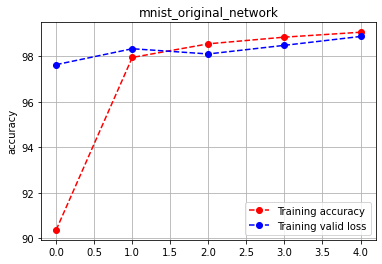

{'accuracy': [90.364, 97.956, 98.556, 98.85, 99.066], 'loss': [0.29661258739920565, 0.06425467679866706, 0.04648363661678762, 0.03605110859342766, 0.02846996144483688], 'valid acc': [0.08052627056272758, 0.053801242265346653, 0.06376210520519271, 0.05315261922943194, 0.042732843348358036], 'valid loss': [97.64, 98.34, 98.11, 98.49, 98.88]}


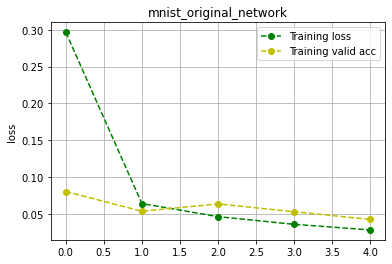

In [16]:
path_mnist_original_network =  './data_vis/ICA/mnist/mnist_original_network_accloss.pickle'

plt_graph(path_mnist_original_network, ('--ro', '--bo'), ('accuracy', 'valid loss'), 'mnist_original_network')
plt_graph(path_mnist_original_network,('--go', '--yo'), ('loss', 'valid acc'), 'mnist_original_network')

{'accuracy': [91.63, 98.186, 98.614, 98.992, 99.164], 'loss': [0.26092222848569957, 0.06024289401060664, 0.04336899876071135, 0.032514313391800026, 0.026531493258883026], 'valid acc': [97.93, 98.47, 98.76, 98.66, 98.96], 'valid loss': [0.0673677414858248, 0.05078865380582852, 0.04378437122237178, 0.046544403300229395, 0.03714979958661078]}


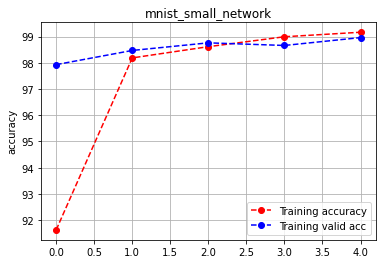

{'accuracy': [91.63, 98.186, 98.614, 98.992, 99.164], 'loss': [0.26092222848569957, 0.06024289401060664, 0.04336899876071135, 0.032514313391800026, 0.026531493258883026], 'valid acc': [97.93, 98.47, 98.76, 98.66, 98.96], 'valid loss': [0.0673677414858248, 0.05078865380582852, 0.04378437122237178, 0.046544403300229395, 0.03714979958661078]}


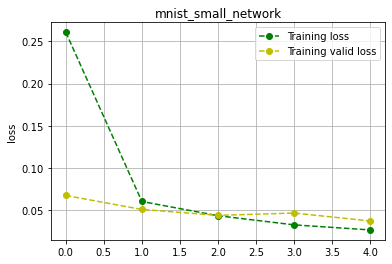

In [19]:
path_mnist_small_network =  './data_vis/ICA/mnist/small_network_mnist_accloss.pickle'

plt_graph(path_mnist_small_network, ('--ro', '--bo'), ('accuracy', 'valid acc'), 'mnist_small_network')
plt_graph(path_mnist_small_network,('--go', '--yo'), ('loss', 'valid loss'), 'mnist_small_network')

{'accuracy': [97.416, 98.608, 99.086, 99.216, 99.354], 'loss': [0.08597036733181682, 0.04271551330684025, 0.029656466026573958, 0.024600348832525896, 0.020581126311458833], 'valid acc': [98.17, 98.49, 98.56, 98.67, 98.74], 'valid loss': [0.06288731332288816, 0.050310564837887276, 0.053591850238959106, 0.06308069046778231, 0.0506829825789312]}


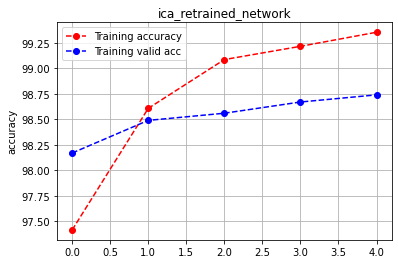

{'accuracy': [97.416, 98.608, 99.086, 99.216, 99.354], 'loss': [0.08597036733181682, 0.04271551330684025, 0.029656466026573958, 0.024600348832525896, 0.020581126311458833], 'valid acc': [98.17, 98.49, 98.56, 98.67, 98.74], 'valid loss': [0.06288731332288816, 0.050310564837887276, 0.053591850238959106, 0.06308069046778231, 0.0506829825789312]}


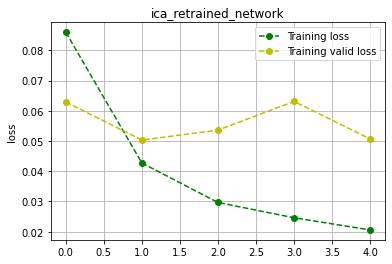

In [21]:
path_mnist_ica_retrained_network =  './data_vis/ICA/mnist/ica_accuracy_loss.pickle'

plt_graph(path_mnist_ica_retrained_network, ('--ro', '--bo'), ('accuracy', 'valid acc'), 'ica_retrained_network')
plt_graph(path_mnist_ica_retrained_network,('--go', '--yo'), ('loss', 'valid loss'), 'ica_retrained_network')

## isomap cifar10

{'accuracy': [34.382222222222225, 40.55555555555556, 43.513333333333335, 45.43555555555555, 47.08888888888889, 48.864444444444445, 50.62222222222222, 52.06, 53.306666666666665, 54.55777777777778], 'loss': [2.0458609574106004, 1.997593827427758, 1.97993847211202, 1.967427443684472, 1.9568164271354676, 1.946690200222863, 1.937205663808187, 1.9278995900154114, 1.9197517955991956, 1.9129876654413012], 'valid acc': [38.68, 42.16, 42.7, 44.92, 47.56, 49.18, 49.82, 51.74, 52.44, 54.04], 'valid loss': [2.0154094702720644, 1.9953443591117859, 1.9833032246589661, 1.9722941647529602, 1.9662027032852172, 1.9514539085388183, 1.9460778294563295, 1.9347130277633666, 1.929883452796936, 1.9249158131599426]}


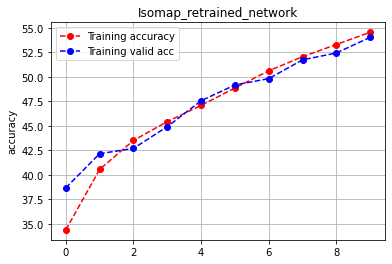

{'accuracy': [34.382222222222225, 40.55555555555556, 43.513333333333335, 45.43555555555555, 47.08888888888889, 48.864444444444445, 50.62222222222222, 52.06, 53.306666666666665, 54.55777777777778], 'loss': [2.0458609574106004, 1.997593827427758, 1.97993847211202, 1.967427443684472, 1.9568164271354676, 1.946690200222863, 1.937205663808187, 1.9278995900154114, 1.9197517955991956, 1.9129876654413012], 'valid acc': [38.68, 42.16, 42.7, 44.92, 47.56, 49.18, 49.82, 51.74, 52.44, 54.04], 'valid loss': [2.0154094702720644, 1.9953443591117859, 1.9833032246589661, 1.9722941647529602, 1.9662027032852172, 1.9514539085388183, 1.9460778294563295, 1.9347130277633666, 1.929883452796936, 1.9249158131599426]}


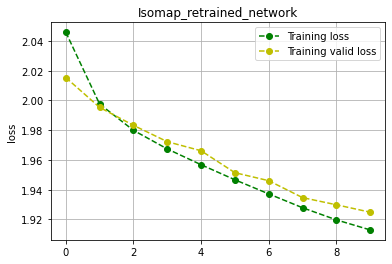

In [44]:
path_mnist_isomap_retrained_network =  './data_vis/isomap/cifar/isomap_accloss.pickle'

plt_graph(path_mnist_isomap_retrained_network, ('--ro', '--bo'), ('accuracy', 'valid acc'), 'Isomap_retrained_network')
plt_graph(path_mnist_isomap_retrained_network,('--go', '--yo'), ('loss', 'valid loss'), 'Isomap_retrained_network')